## Create labels

In [ ]:
import json

In [ ]:
def get_thresh(max, min, k):
  return max - k * (max - min)

datasplits = ['test', 'train', 'val']

In [ ]:
import math

for split in datasplits:

  thresh_dict = {}

  with open('%s_annotation.json' % split) as f:
    annotation = json.load(f)

  for img_id, data in annotation.items():

    min = float(data[0]['min_area'])
    max = float(data[0]['max_area'])
    k = float(data[1]['objects'][0]['k'])

    T = get_thresh(max, min, k)

    thresh_dict[img_id] = math.sqrt(T / (1024**2))
    # thresh_dict[img_id] = T
    # thresh_dict[img_id] = T / (1478**2), 7)

  with open('%s_thresholds_norm.json' % split, 'w+') as f_out:
    json.dump(thresh_dict, f_out)

In [ ]:
for split in datasplits:

  thresh_labels = {}

  with open('%s_questions.json' % split) as f:
    questions = json.load(f)['questions']
  
  with open('%s_thresholds_norm.json' % split) as f:
    thresholds = json.load(f)

  for q in questions:
    if q['question_index'] % 6 == 0:
      thresh_labels[q['image_index']] = []
      for imgfile in q['images_shuffled']:
        imgid = imgfile.split('.')[0]
        thresh_labels[q['image_index']].append(thresholds[imgid])

  with open('%s_thresh_labels.json' % split, 'w+') as f_out:
    json.dump(thresh_labels, f_out)
    

Classifiers

In [ ]:
import keras
from keras import backend
import tensorflow as tf
from tensorflow.python.framework import ops

import glob
import numpy as np

seed_value = 12321

import os
os.environ['PYTHONHASHSEED']=str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

import tensorflow.python.keras.backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=ops.get_default_graph(), config=session_conf)
K.set_session(sess)

In [ ]:
valid_path = "/content/drive/My Drive/probing, 3 images/valid/cross_feats/"
valid_stack = []

for np_name in glob.glob(valid_path + '*.npy'):
    valid_features = np.load(np_name)
    valid_stack.append(valid_features)

valid_features = np.stack(valid_stack)
valid_x = np.reshape(valid_features, (6000, 768))
valid_x.shape

(6000, 768)

In [ ]:
# load test features
test_path = "/content/drive/My Drive/probing, 3 images/test/cross_feats/"
test_stack = []

for np_name in glob.glob(test_path + '*.npy'):
    test_features = np.load(np_name)
    test_stack.append(test_features)

test_features = np.stack(test_stack)
test_x = np.reshape(test_features, (6000, 768))
test_x.shape

(6000, 768)

In [ ]:
# load train features
train_path = "/content/drive/My Drive/probing, 3 images/train/cross_feats/"
train_stack = []

for np_name in glob.glob(train_path + '*.npy'):
    train_features = np.load(np_name)
    train_stack.append(train_features)

train_features = np.stack(train_stack)
train_x = np.reshape(train_features, (48000, 768))
train_x.shape

(48000, 768)

In [ ]:
# prepare labels
train_labels_path = "train_thresh_labels.json"
test_labels_path = "test_thresh_labels.json"
valid_labels_path = "val_thresh_labels.json"

with open(train_labels_path) as f:
    train_labels_dict = json.load(f)
train_y = []
for key, labels in train_labels_dict.items():
  train_y.extend(labels)
# train_y = keras.utils.to_categorical(np.asarray(train_y))

with open(valid_labels_path) as f:
    valid_labels_dict = json.load(f)
valid_y = []
for key, labels in valid_labels_dict.items():
  valid_y.extend(labels)
# valid_y = keras.utils.to_categorical(np.asarray(valid_y))

with open(test_labels_path) as f:
    test_labels_dict = json.load(f)
test_y = []
for key, labels in test_labels_dict.items():
  test_y.extend(labels)
# test_y = keras.utils.to_categorical(np.asarray(test_y))

In [ ]:
model_mlp = keras.models.Sequential([
    keras.layers.Dense((512), input_shape=[768], activation=keras.activations.relu),
    keras.layers.Dense((128), activation=keras.activations.relu),
    keras.layers.Dense((1), activation=keras.activations.linear),
])

adam = keras.optimizers.Adam(lr=0.001)
model_mlp.compile(loss='mean_absolute_error', optimizer=adam, metrics=['mean_squared_error'])

In [ ]:
import numpy as np
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model_mlp.fit(
    train_x, 
    np.asarray(train_y), 
    epochs=10,
    verbose=1, 
    batch_size=32,
    shuffle=True, 
    validation_data=(valid_x, np.asarray(valid_y)))

Epoch 1/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0246 - mean_squared_error: 0.0096 - val_loss: 0.0128 - val_mean_squared_error: 2.6713e-04
Epoch 2/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0109 - mean_squared_error: 2.0271e-04 - val_loss: 0.0080 - val_mean_squared_error: 1.0074e-04
Epoch 3/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0100 - mean_squared_error: 1.7386e-04 - val_loss: 0.0077 - val_mean_squared_error: 9.3628e-05
Epoch 4/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0097 - mean_squared_error: 1.6620e-04 - val_loss: 0.0077 - val_mean_squared_error: 9.2731e-05
Epoch 5/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0095 - mean_squared_error: 1.6077e-04 - val_loss: 0.0077 - val_mean_squared_error: 9.2458e-05
Epoch 6/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0093 - mean_squared_error: 1.5670e-04 - val_loss: 0.0074 - val_mea

In [ ]:
model_mlp.evaluate(test_x, np.asarray(test_y))

188/188 [==============================] - 0s 1ms/step - loss: 0.0071 - mean_squared_error: 8.0879e-05


[0.0070750415325164795, 8.087944297585636e-05]

In [ ]:
predicted_mlp = model_mlp.predict(test_x)

In [ ]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(train_x, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
test_pred = reg.predict(test_x)

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
mean_squared_error(test_pred, test_y)

0.0001384408066882509

In [ ]:
valid_pred = reg.predict(valid_x)
mean_squared_error(valid_pred, valid_y)

0.00013131884860701518

In [ ]:
target_sorted, predicted_sorted = zip(*sorted(zip(test_y, test_pred)))

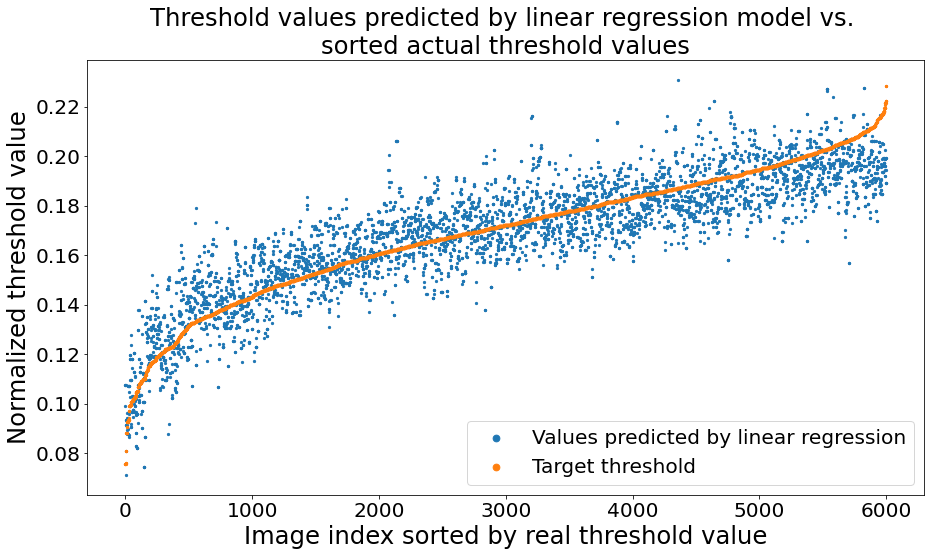

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}

pylab.rcParams.update(params)

plt.figure(figsize=(15,8))
plt.scatter(range(len(predicted_sorted)), predicted_sorted, label = "Values predicted by linear regression", s=5)
plt.scatter(range(len(target_sorted)), target_sorted, label = "Target threshold", s=5)
plt.xlabel('Image index sorted by real threshold value')
# Set the y axis label of the current axis.
plt.ylabel('Normalized threshold value')
# Set a title of the current axes.
plt.title('Threshold values predicted by linear regression model vs. \nsorted actual threshold values')
# show a legend on the plot
plt.legend(markerscale=3.)
# Display a figure.
plt.show()

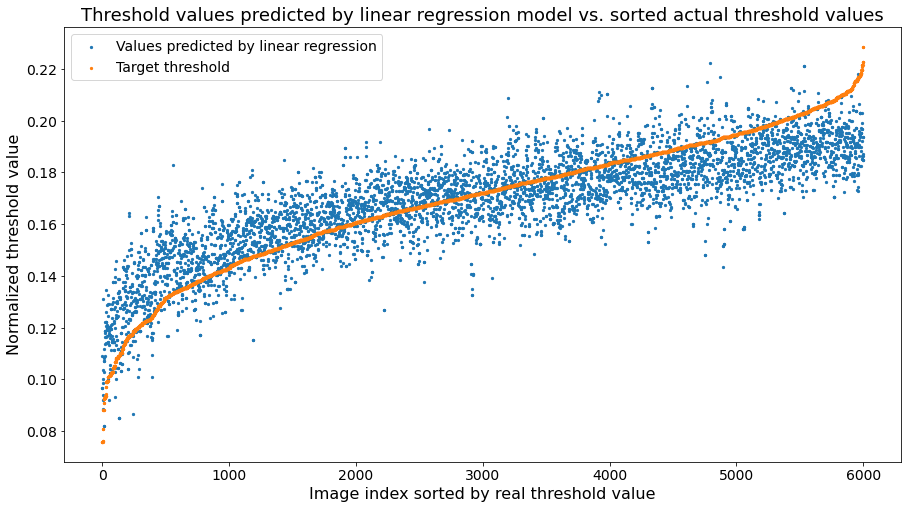

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(15,8))
plt.scatter(range(len(predicted_sorted)), predicted_sorted, label = "Values predicted by linear regression", s=5)
plt.scatter(range(len(target_sorted)), target_sorted, label = "Target threshold", s=5)
plt.xlabel('Image index sorted by real threshold value', fontsize=16)
# Set the y axis label of the current axis.
plt.ylabel('Normalized threshold value', fontsize=16)
# Set a title of the current axes.
plt.title('Threshold values predicted by linear regression model vs. sorted actual threshold values', fontsize=18)
# show a legend on the plot
plt.legend(fontsize=14)
# Display a figure.
plt.show()

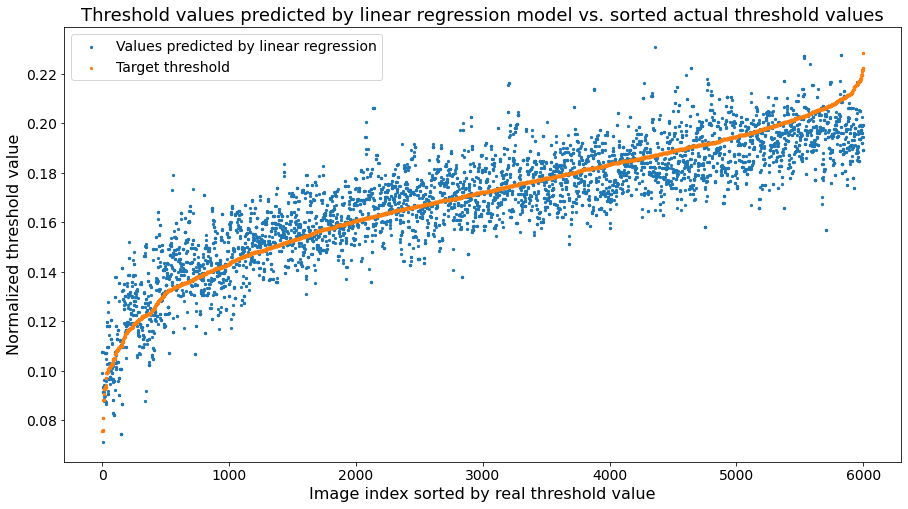

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(15,8))
plt.scatter(range(len(predicted_sorted)), predicted_sorted, label = "Values predicted by linear regression", s=5)
plt.scatter(range(len(target_sorted)), target_sorted, label = "Target threshold", s=5)
plt.xlabel('Image index sorted by real threshold value', fontsize=16)
# Set the y axis label of the current axis.
plt.ylabel('Normalized threshold value', fontsize=16)
# Set a title of the current axes.
plt.title('Threshold values predicted by linear regression model vs. sorted actual threshold values', fontsize=18)
# show a legend on the plot
plt.legend(fontsize=14)
# Display a figure.
plt.show()

In [ ]:
target_sorted, predicted_mlp_sorted = zip(*sorted(zip(test_y, predicted_mlp)))

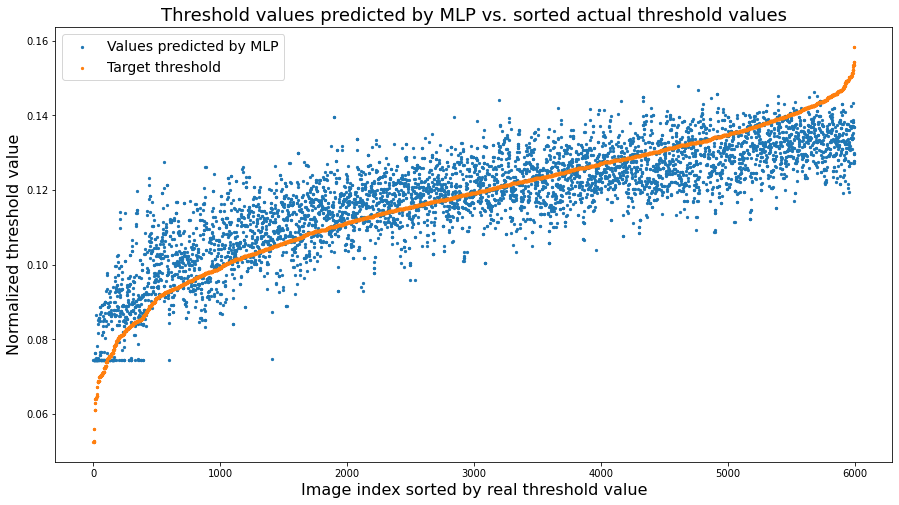

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
plt.scatter(range(len(predicted_mlp_sorted)), predicted_mlp_sorted, label = "Values predicted by MLP", s=5)
plt.scatter(range(len(target_sorted)), target_sorted, label = "Target threshold", s=5)
plt.xlabel('Image index sorted by real threshold value', fontsize=16)
# Set the y axis label of the current axis.
plt.ylabel('Normalized threshold value', fontsize=16)
# Set a title of the current axes.
plt.title('Threshold values predicted by MLP vs. sorted actual threshold values', fontsize=18)
# show a legend on the plot
plt.legend(fontsize=14)
# Display a figure.
plt.show()

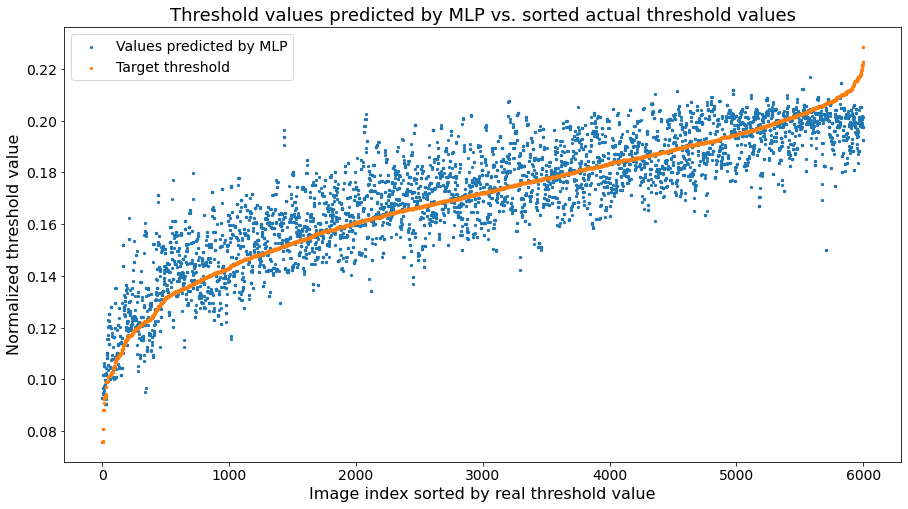

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
plt.scatter(range(len(predicted_mlp_sorted)), predicted_mlp_sorted, label = "Values predicted by MLP", s=5)
plt.scatter(range(len(target_sorted)), target_sorted, label = "Target threshold", s=5)
plt.xlabel('Image index sorted by real threshold value', fontsize=16)
# Set the y axis label of the current axis.
plt.ylabel('Normalized threshold value', fontsize=16)
# Set a title of the current axes.
plt.title('Threshold values predicted by MLP vs. sorted actual threshold values', fontsize=18)
# show a legend on the plot
plt.legend(fontsize=14)
# Display a figure.
plt.show()

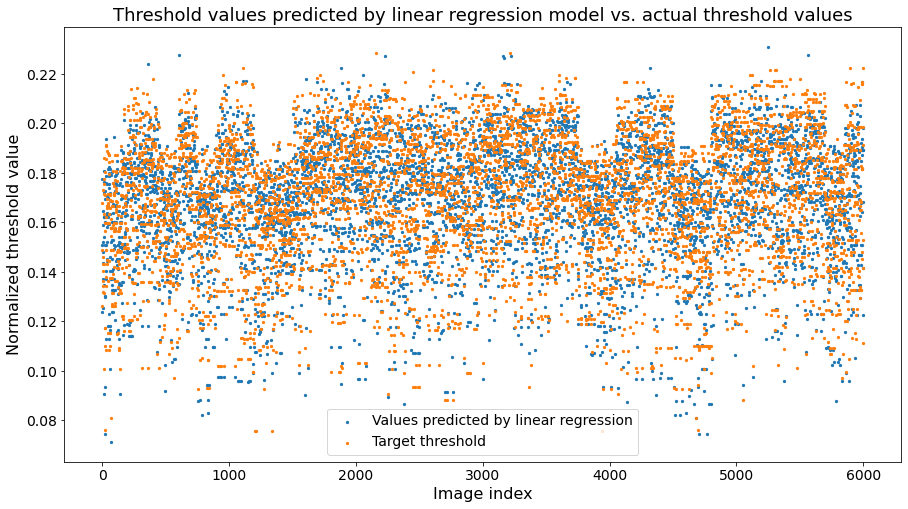

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
plt.scatter(range(len(test_pred)), test_pred, label = "Values predicted by linear regression", s=5)
plt.scatter(range(len(test_y)), test_y, label = "Target threshold", s=5)
plt.xlabel('Image index', fontsize=16)
# Set the y axis label of the current axis.
plt.ylabel('Normalized threshold value', fontsize=16)
# Set a title of the current axes.
plt.title('Threshold values predicted by linear regression model vs. actual threshold values', fontsize=18)
# show a legend on the plot
plt.legend(fontsize=14)
# Display a figure.
plt.show()

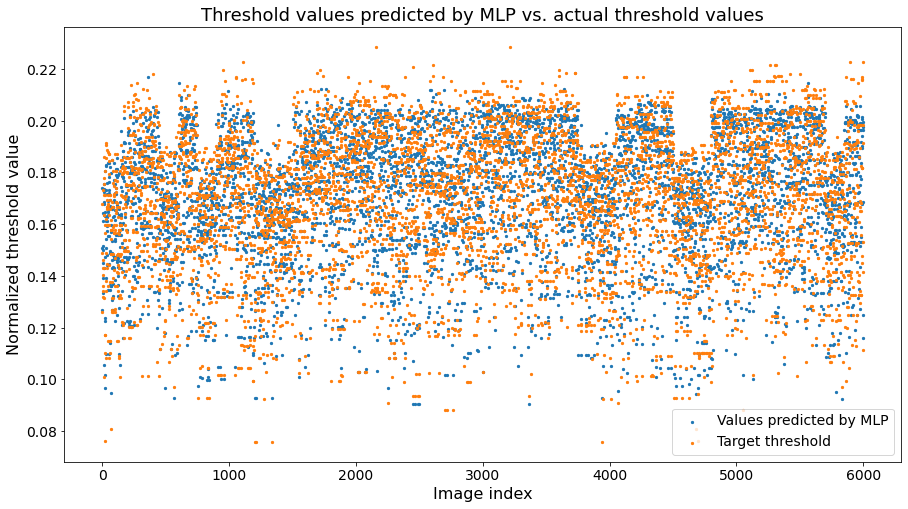

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
plt.scatter(range(len(predicted_mlp)), predicted_mlp, label = "Values predicted by MLP", s=5)
plt.scatter(range(len(test_y)), test_y, label = "Target threshold", s=5)
plt.xlabel('Image index', fontsize=16)
# Set the y axis label of the current axis.
plt.ylabel('Normalized threshold value', fontsize=16)
# Set a title of the current axes.
plt.title('Threshold values predicted by MLP vs. actual threshold values', fontsize=18)
# show a legend on the plot
plt.legend(fontsize=14)
# Display a figure.
plt.show()

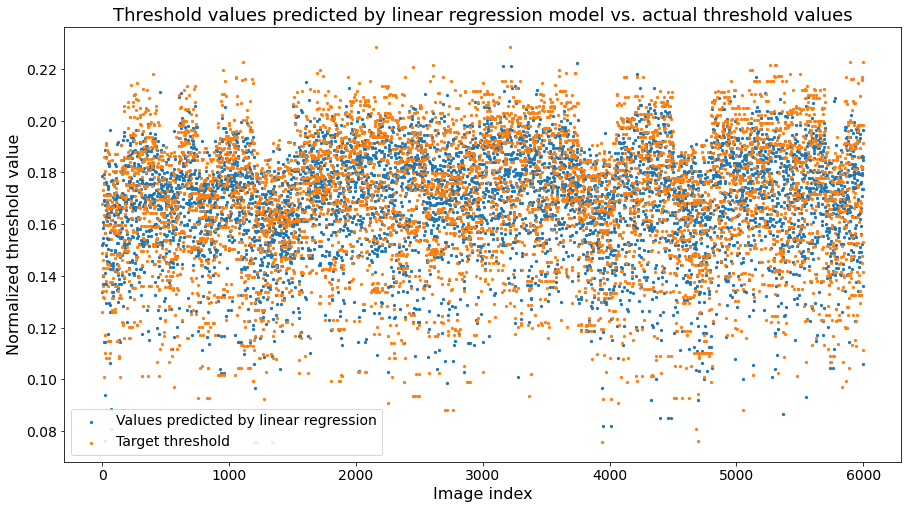

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
plt.scatter(range(len(test_pred)), test_pred, label = "Values predicted by linear regression", s=5)
plt.scatter(range(len(test_y)), test_y, label = "Target threshold", s=5)
plt.xlabel('Image index', fontsize=16)
# Set the y axis label of the current axis.
plt.ylabel('Normalized threshold value', fontsize=16)
# Set a title of the current axes.
plt.title('Threshold values predicted by linear regression model vs. actual threshold values', fontsize=18)
# show a legend on the plot
plt.legend(fontsize=14)
# Display a figure.
plt.show()